Introduction

This inquiry seeks for indicators that may foretell if a student will graduate.
The project unfolds as follows:
1. Importing the libraries and data
2. Becoming acquainted with the shape
3. Sifting through the data if necessary
4. Uncovering correlations
5. Training a prognostic model

Step 1. Self-explanatory.

In [212]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics


In [213]:
df = pd.read_csv("data/dataset.csv")

Step 2. Looking at it.

In [214]:
df

,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Nacionality,Mother's qualification,Father's qualification,Mother's occupation,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,8,5,2,1,1,1,13,10,6,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,6,1,11,1,1,1,1,3,4,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,5,1,1,1,22,27,10,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,8,2,15,1,1,1,23,27,6,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,12,1,3,0,1,1,22,28,10,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,15,1,1,1,1,1,6,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,15,1,1,19,1,1,10,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,12,1,1,1,22,27,10,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9,1,1,1,22,27,8,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


Many columns values are categorical but indexed. Descriptions are found at the end of research paper that came with dataset, for now i'll leave everything as is

Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


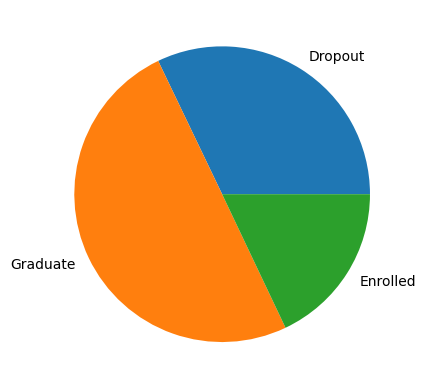

In [215]:
plt.pie(df.Target.value_counts(sort=False), labels=df.Target.unique()) # better syntax? .unique(return_counts=True) seemed promising
print(df.Target.value_counts())

Step 3. Eliminating the unwanted.

Although the enrolled students could marginally affect the results, i excluded them from handling to make my life easier. Along the way i changed contents to 0 for "Droppout" and 1 for "Graduate"

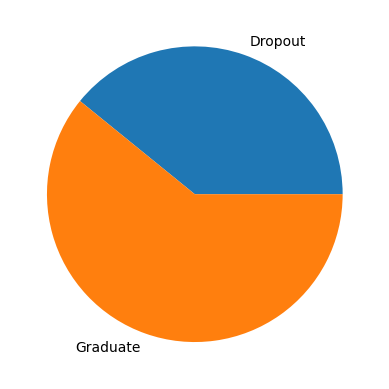

In [216]:
df = df.loc[((df.Target == "Dropout") | (df.Target == "Graduate")),:]
plt.pie(df.Target.value_counts(sort=False), labels=df.Target.unique())
df.loc[:,"Target"] = df.Target.map({"Dropout":0, "Graduate":1})

I also excluded all curricular units as they correlate but at the same time they are not the goal of my study

In [217]:
df = df.drop(list(df.filter(regex = "Curricular units")), axis = 1)

Step 4. Finding some relations<span style="color:#424242">hip</span>

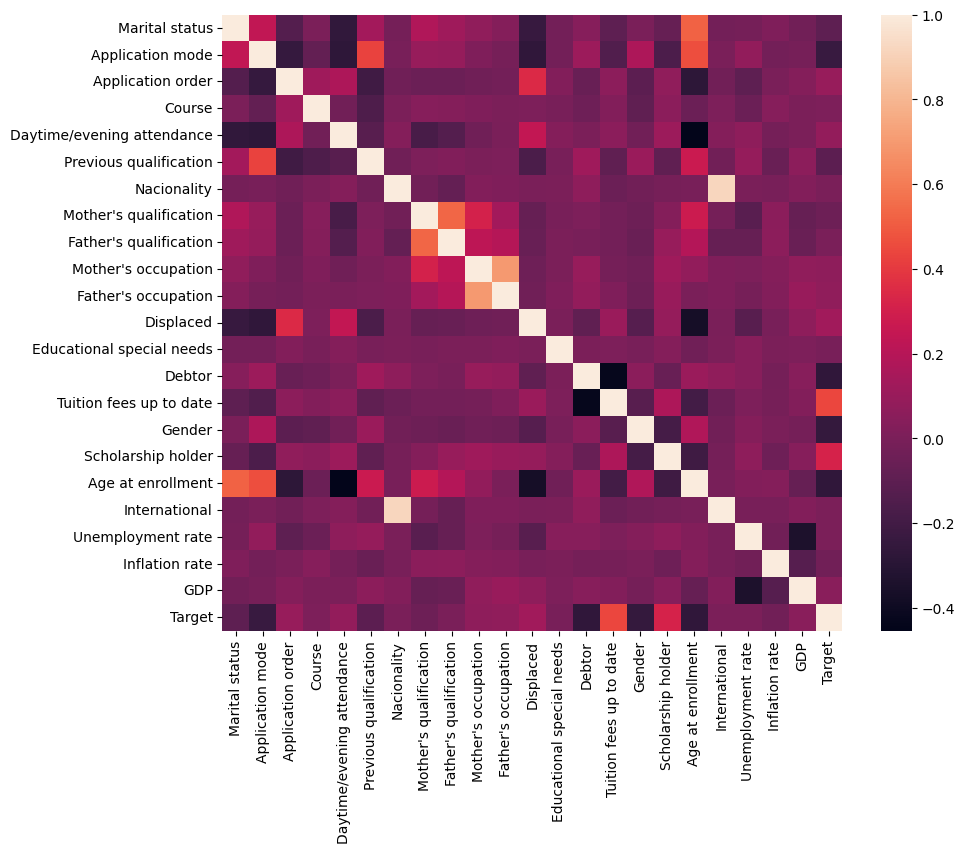

In [218]:
plt.figure(figsize = (10,8))
plot = sns.heatmap(df.corr())

A heatmap certifies that ones parents may rather have similar qualification and occupation, that being older greatly increases the probability of not being single, potentialy even divorced or widowed, and that having a foreign nationality suggests you being an international student.

Now these are some of that we've been actually looking for:
1. Being a male severely increases the chance that you'll drop, probably for both social and biological reasons.
2. Younger people tend to graduate, so getting a degree late is rather unlikely even if you manage to enroll.
3. If one gets scholarship, he probably graduates, although just paying in time and not being in debt is even more promising.

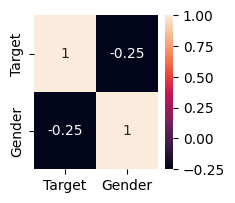

In [219]:
plt.figure(figsize = (2,2))
plot = sns.heatmap(df.loc[:,["Target", "Gender"]].corr().round(2),annot=True)

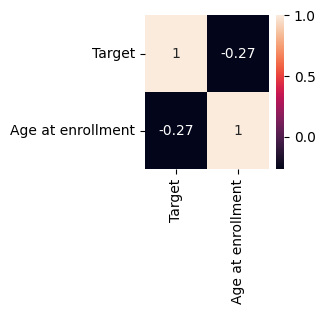

In [220]:
plt.figure(figsize = (2,2))
plot = sns.heatmap(df.loc[:,["Target", "Age at enrollment"]].corr().round(2),annot=True)

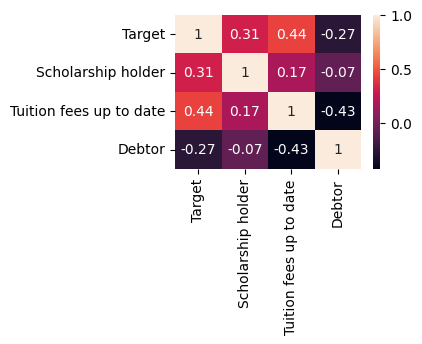

In [221]:
plt.figure(figsize = (3,2)) 
plot = sns.heatmap(df.loc[:,["Target", "Scholarship holder", "Tuition fees up to date", "Debtor"]].corr().round(2),annot=True)

Step 4. Considerably less fun.

To be honest, at this point i know much less of what am i doing. I've been testing different models i've never touched before for about 2 days and came back to K Neighbours

In [222]:
y = df.Target.astype(np.int64)
df.drop(["Target"], axis=1, inplace=True)
df.iloc[:-3] = df.iloc[:-3].astype(np.int64)
X = df

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

In [223]:
from sklearn.neighbors import KNeighborsClassifier

In [224]:
k_range = range(1,100)
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

76


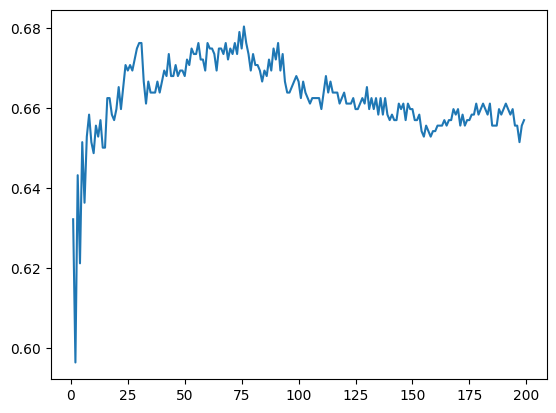

In [225]:
plt.plot(k_range, scores_list)
print(k_range[scores_list.index(max(scores_list))])

With the random state of "1234" i got decent results at K = 30. I tried it further, it gets even better at 76. Then it goes down (at least up to 200)

Time to change the random state.

14


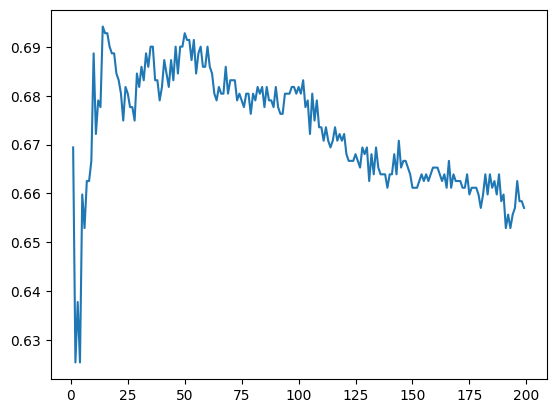

In [226]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=256)

k_range = range(1,100)
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores_list)
print(k_range[scores_list.index(max(scores_list))])

22


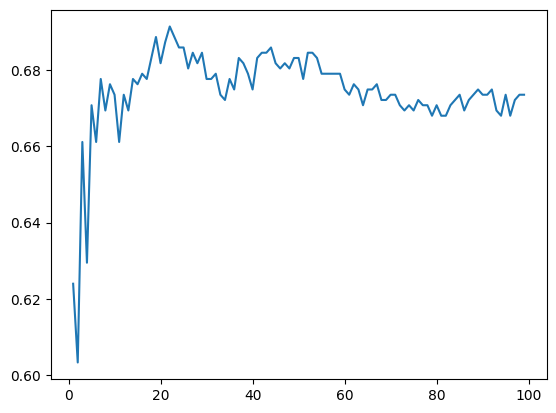

In [227]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=13042023)

k_range = range(1,100)
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    scores_list.append(metrics.accuracy_score(y_test, y_pred))

plt.plot(k_range, scores_list)
print(k_range[scores_list.index(max(scores_list))])

Well, they differ much, and there is no magical number of neighbours. What a shame

For now i'm not sure if .67 on average is any good